In [1]:
from openpyxl import Workbook
from openpyxl import load_workbook
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import statsmodels.api as sm
from sklearn import metrics
from random import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from sklearn.svm import SVR

Using TensorFlow backend.


In [2]:
data = pd.read_csv("data.csv")
data = data.sample(frac=1).reset_index(drop=True)
pd.options.mode.chained_assignment = None


# XLabels = ['TotalT','Temp','LSR','CA','Size', 'Moisture', 'IsoT', 'HeatT', 'Ramp','F_X']
XLabels = ['TotalT','Temp','LSR','CA','Size', 'Moisture', 'IsoT', 'HeatT', 'Ramp','F_X']
#XLabels = ['TotalT','Temp','LSR','CA','Size', 'Moisture', 'IsoT', 'HeatT', 'Ramp','F_X', 'Ro', 'logRo', 'P', 'logP']
X = data[XLabels]
#Scaling X
sc = StandardScaler()
X = sc.fit_transform(X)
data[XLabels] = X


print(type(X))

numData = len(data.index)
numTrain = int(numData * 0.7)
numTest = int(numData * .15) 
# print(numTest, numTrain)
train_Frame, valid_Frame, test_Frame, train_valid_Frame = data.iloc[:numTrain, :], data.iloc[numTrain:-numTest, :], data.iloc[-numTest:, :], data.iloc[:-numTest:, :]





<class 'numpy.ndarray'>


TotalT
Lowest Error In Validation _MSE_  9.41921840289435
Temp
Lowest Error In Validation _MSE_  10.971800705407274
LSR
Lowest Error In Validation _MSE_  9.097710987588563
CA
Lowest Error In Validation _MSE_  9.73268909571978
Size
Lowest Error In Validation _MSE_  8.854823806401171
Moisture
Lowest Error In Validation _MSE_  9.158017757039117
IsoT
Lowest Error In Validation _MSE_  9.52290926156128
HeatT
Lowest Error In Validation _MSE_  9.002401863898305
Ramp
Lowest Error In Validation _MSE_  8.819382696299028
F_X
Lowest Error In Validation _MSE_  8.784674191796233
Lowest Error In Validation _MSE_  9.034858905479727


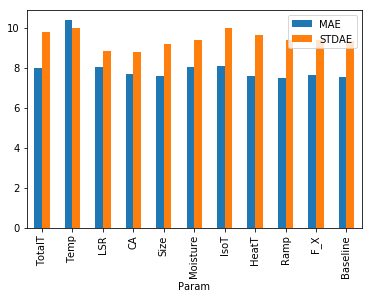

In [3]:
#SVR

resultsFrame = pd.DataFrame(columns=['Param', 'MAE', 'STDAE'])

for i in XLabels:
    print(i)
    remainingX = XLabels.copy()
    remainingX.remove(i)
    
    X = data[remainingX].values
    y_train, y_valid, y_test, y_train_valid = train_Frame['Yield'], valid_Frame['Yield'], test_Frame['Yield'], train_valid_Frame['Yield']
    X_train, X_valid, X_test, X_train_valid = X[:numTrain, :], X[numTrain:-numTest, :], X[-numTest:, :], X[:-numTest, :]

    
    kernels =  ['poly', 'rbf', 'linear']
    epsilons = [0.1,5,10, 20]
    Cs = [0.1,1,10, 20]
    gammas = ['scale', 'auto']
    errors = []

    for kern in kernels:
        for ep in epsilons:
            for C_ in Cs:
                for gam in gammas:
                    svrModel = SVR(kernel=kern, gamma=gam, epsilon=ep, cache_size=2000, C=C_)
    #                 svrModel.fit(X_train, y_train, sample_weight=train_weights)
                    svrModel.fit(X_train, y_train)
                    y_pred = svrModel.predict(X_valid)
                    error =  metrics.mean_absolute_error(y_valid, y_pred)
                    errors.append(error)


    index_of_lowest_error = np.argmin(errors)
    print("Lowest Error In Validation _MSE_ ", np.min(errors))

    best_kernel = kernels[int(index_of_lowest_error / (len(epsilons) * len(Cs) * len(gammas)))] #Good
    best_ep = epsilons[int((index_of_lowest_error % (len(epsilons) *len(Cs) * len(gammas)))/(len(Cs) *len(gammas)))] #Good
    best_C = Cs[int((index_of_lowest_error % (len(Cs) * len(gammas)))/len(gammas))] #Good 
    best_gamma = gammas[int(index_of_lowest_error % len(gammas))]

#     print("Best kernel is: ", best_kernel)
#     print("Best Epsilon is: ", best_ep)
#     print("Best C is: ", best_C)
#     print("Best Gamma is: ", best_gamma)



    best_model = SVR(kernel=best_kernel, gamma=best_gamma, epsilon=best_ep, cache_size=2000, C=best_C)
    # best_model.fit(X_train_valid, y_train_valid, sample_weight=train_valid_weights)
    best_model.fit(X_train_valid, y_train_valid)
    y_pred = best_model.predict(X_test)

    
    error = metrics.mean_absolute_error(y_test, y_pred)
    diff = np.absolute(y_test - y_pred)
    stdev = np.std(diff)
    
    row = [[i, error, stdev]]
    tempDf = pd.DataFrame(row, columns=['Param', 'MAE', 'STDAE'])
    resultsFrame = pd.concat([resultsFrame, tempDf], ignore_index=True)

    
##
X = data[XLabels].values
y_train, y_valid, y_test, y_train_valid = train_Frame['Yield'], valid_Frame['Yield'], test_Frame['Yield'], train_valid_Frame['Yield']
X_train, X_valid, X_test, X_train_valid = X[:numTrain, :], X[numTrain:-numTest, :], X[-numTest:, :], X[:-numTest, :]


kernels =  ['poly', 'rbf', 'linear']
epsilons = [0.1,5,10, 20]
Cs = [0.1,1,10, 20]
gammas = ['scale', 'auto']
errors = []

for kern in kernels:
    for ep in epsilons:
        for C_ in Cs:
            for gam in gammas:
                svrModel = SVR(kernel=kern, gamma=gam, epsilon=ep, cache_size=2000, C=C_)
#                 svrModel.fit(X_train, y_train, sample_weight=train_weights)
                svrModel.fit(X_train, y_train)
                y_pred = svrModel.predict(X_valid)
                error =  metrics.mean_absolute_error(y_valid, y_pred)
                errors.append(error)


index_of_lowest_error = np.argmin(errors)
print("Lowest Error In Validation _MSE_ ", np.min(errors))

best_kernel = kernels[int(index_of_lowest_error / (len(epsilons) * len(Cs) * len(gammas)))] #Good
best_ep = epsilons[int((index_of_lowest_error % (len(epsilons) *len(Cs) * len(gammas)))/(len(Cs) *len(gammas)))] #Good
best_C = Cs[int((index_of_lowest_error % (len(Cs) * len(gammas)))/len(gammas))] #Good 
best_gamma = gammas[int(index_of_lowest_error % len(gammas))]

#     print("Best kernel is: ", best_kernel)
#     print("Best Epsilon is: ", best_ep)
#     print("Best C is: ", best_C)
#     print("Best Gamma is: ", best_gamma)



best_model = SVR(kernel=best_kernel, gamma=best_gamma, epsilon=best_ep, cache_size=2000, C=best_C)
# best_model.fit(X_train_valid, y_train_valid, sample_weight=train_valid_weights)
best_model.fit(X_train_valid, y_train_valid)
y_pred = best_model.predict(X_test)


error = metrics.mean_absolute_error(y_test, y_pred)
diff = np.absolute(y_test - y_pred)
stdev = np.std(diff)

row = [["Baseline", error, stdev]]
tempDf = pd.DataFrame(row, columns=['Param', 'MAE', 'STDAE'])
resultsFrame = pd.concat([resultsFrame, tempDf], ignore_index=True)
###
    

resultsFrame.to_csv("paraemtersWithoutRoP.csv")
resultsFrame.plot(kind='bar', stacked=False, x='Param')

    

In [ ]:
#SVR

resultsFrame = pd.DataFrame(columns=['Param', 'MAE', 'STDAE'])

for i in ['Ro', 'LogRo', 'P', 'LogP']:
    print(i)
    remainingX = XLabels.copy()
    remainingX.append(i)
#     print(remainingX)
    

    
    X = data[remainingX].values
    y_train, y_valid, y_test, y_train_valid = train_Frame['Yield'], valid_Frame['Yield'], test_Frame['Yield'], train_valid_Frame['Yield']
    X_train, X_valid, X_test, X_train_valid = X[:numTrain, :], X[numTrain:-numTest, :], X[-numTest:, :], X[:-numTest, :]

    
    kernels =  ['poly', 'rbf', 'linear']
    epsilons = [0.1,5,10, 20]
    Cs = [0.1,1,10, 20]
    gammas = ['scale', 'auto']
    errors = []

    for kern in kernels:
        for ep in epsilons:
            for C_ in Cs:
                for gam in gammas:
                    svrModel = SVR(kernel=kern, gamma=gam, epsilon=ep, cache_size=2000, C=C_)
    #                 svrModel.fit(X_train, y_train, sample_weight=train_weights)
                    svrModel.fit(X_train, y_train)
                    y_pred = svrModel.predict(X_valid)
                    error =  metrics.mean_absolute_error(y_valid, y_pred)
                    errors.append(error)


    index_of_lowest_error = np.argmin(errors)
    print("Lowest Error In Validation _MSE_ ", np.min(errors))

    best_kernel = kernels[int(index_of_lowest_error / (len(epsilons) * len(Cs) * len(gammas)))] #Good
    best_ep = epsilons[int((index_of_lowest_error % (len(epsilons) *len(Cs) * len(gammas)))/(len(Cs) *len(gammas)))] #Good
    best_C = Cs[int((index_of_lowest_error % (len(Cs) * len(gammas)))/len(gammas))] #Good 
    best_gamma = gammas[int(index_of_lowest_error % len(gammas))]

#     print("Best kernel is: ", best_kernel)
#     print("Best Epsilon is: ", best_ep)
#     print("Best C is: ", best_C)
#     print("Best Gamma is: ", best_gamma)



    best_model = SVR(kernel=best_kernel, gamma=best_gamma, epsilon=best_ep, cache_size=2000, C=best_C)
    # best_model.fit(X_train_valid, y_train_valid, sample_weight=train_valid_weights)
    best_model.fit(X_train_valid, y_train_valid)
    y_pred = best_model.predict(X_test)

    
    error = metrics.mean_absolute_error(y_test, y_pred)
    diff = np.absolute(y_test - y_pred)
    stdev = np.std(diff)
    
    row = [[i, error, stdev]]
    tempDf = pd.DataFrame(row, columns=['Param', 'MAE', 'STDAE'])
    resultsFrame = pd.concat([resultsFrame, tempDf], ignore_index=True)

resultsFrame.to_csv("paraemtersWithRoP.csv")
resultsFrame.plot(kind='bar', stacked=False, x='Param')

    

Ro


TotalT
Temp
LSR
CA
Size
Moisture
IsoT
HeatT
Ramp
F_X
Lowest Error In Validation _MSE_  9.034858905479727


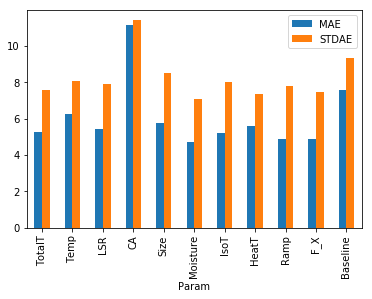

In [4]:
#NN

resultsFrame = pd.DataFrame(columns=['Param', 'MAE', 'STDAE'])

for i in XLabels:
    print(i)
    remainingX = XLabels.copy()
    remainingX.remove(i)
    
    X = data[remainingX].values
    y_train, y_valid, y_test, y_train_valid = train_Frame['Yield'], valid_Frame['Yield'], test_Frame['Yield'], train_valid_Frame['Yield']
    X_train, X_valid, X_test, X_train_valid = X[:numTrain, :], X[numTrain:-numTest, :], X[-numTest:, :], X[:-numTest, :]

    
    best_lr = 0.02
    best_bs = 128
    best_dr = 0.1

    #Using best values

    model = Sequential()
    model.add(Dense(units=12, activation='sigmoid', input_dim=9))
    model.add(Dropout(best_dr))
    model.add(Dense(units=12, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=1, activation='softplus'))

    sgd = SGD(lr=best_lr)  
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

    model.fit(X_train_valid, y_train_valid, epochs=3000, batch_size=best_bs ,verbose=0)

    # loss_and_metrics = model.evaluate(X_test, y_test,batch_size=best_bs)

    y_pred = model.predict(X_test, batch_size=best_bs)
    y_pred = y_pred.flatten()
    
    error = metrics.mean_absolute_error(y_test, y_pred)
    diff = np.absolute(y_test - y_pred)
    stdev = np.std(diff)
    
    row = [[i, error, stdev]]
    tempDf = pd.DataFrame(row, columns=['Param', 'MAE', 'STDAE'])
    resultsFrame = pd.concat([resultsFrame, tempDf], ignore_index=True)
##
X = data[XLabels].values
y_train, y_valid, y_test, y_train_valid = train_Frame['Yield'], valid_Frame['Yield'], test_Frame['Yield'], train_valid_Frame['Yield']
X_train, X_valid, X_test, X_train_valid = X[:numTrain, :], X[numTrain:-numTest, :], X[-numTest:, :], X[:-numTest, :]


kernels =  ['poly', 'rbf', 'linear']
epsilons = [0.1,5,10, 20]
Cs = [0.1,1,10, 20]
gammas = ['scale', 'auto']
errors = []

for kern in kernels:
    for ep in epsilons:
        for C_ in Cs:
            for gam in gammas:
                svrModel = SVR(kernel=kern, gamma=gam, epsilon=ep, cache_size=2000, C=C_)
#                 svrModel.fit(X_train, y_train, sample_weight=train_weights)
                svrModel.fit(X_train, y_train)
                y_pred = svrModel.predict(X_valid)
                error =  metrics.mean_absolute_error(y_valid, y_pred)
                errors.append(error)


index_of_lowest_error = np.argmin(errors)
print("Lowest Error In Validation _MSE_ ", np.min(errors))

best_kernel = kernels[int(index_of_lowest_error / (len(epsilons) * len(Cs) * len(gammas)))] #Good
best_ep = epsilons[int((index_of_lowest_error % (len(epsilons) *len(Cs) * len(gammas)))/(len(Cs) *len(gammas)))] #Good
best_C = Cs[int((index_of_lowest_error % (len(Cs) * len(gammas)))/len(gammas))] #Good 
best_gamma = gammas[int(index_of_lowest_error % len(gammas))]

#     print("Best kernel is: ", best_kernel)
#     print("Best Epsilon is: ", best_ep)
#     print("Best C is: ", best_C)
#     print("Best Gamma is: ", best_gamma)



best_model = SVR(kernel=best_kernel, gamma=best_gamma, epsilon=best_ep, cache_size=2000, C=best_C)
# best_model.fit(X_train_valid, y_train_valid, sample_weight=train_valid_weights)
best_model.fit(X_train_valid, y_train_valid)
y_pred = best_model.predict(X_test)


error = metrics.mean_absolute_error(y_test, y_pred)
diff = np.absolute(y_test - y_pred)
stdev = np.std(diff)

row = [["Baseline", error, stdev]]
tempDf = pd.DataFrame(row, columns=['Param', 'MAE', 'STDAE'])
resultsFrame = pd.concat([resultsFrame, tempDf], ignore_index=True)
###
        

resultsFrame.to_csv("NNparaemtersWithoutRoP.csv")
resultsFrame.plot(kind='bar', stacked=False, x='Param')

    

Ro
LogRo
P
LogP


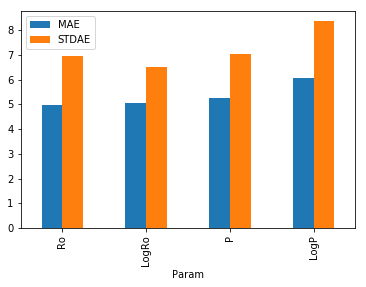

In [5]:
#SVR

resultsFrame = pd.DataFrame(columns=['Param', 'MAE', 'STDAE'])

for i in ['Ro', 'LogRo', 'P', 'LogP']:
    print(i)
    remainingX = XLabels.copy()
    remainingX.append(i)
#     print(remainingX)
    

    
    X = data[remainingX].values
    y_train, y_valid, y_test, y_train_valid = train_Frame['Yield'], valid_Frame['Yield'], test_Frame['Yield'], train_valid_Frame['Yield']
    X_train, X_valid, X_test, X_train_valid = X[:numTrain, :], X[numTrain:-numTest, :], X[-numTest:, :], X[:-numTest, :]

    
    best_lr = 0.02
    best_bs = 128
    best_dr = 0.1

    #Using best values

    model = Sequential()
    model.add(Dense(units=12, activation='sigmoid', input_dim=10))
    model.add(Dropout(best_dr))
    model.add(Dense(units=12, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=1, activation='softplus'))

    sgd = SGD(lr=best_lr)  
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

    model.fit(X_train_valid, y_train_valid, epochs=3000, batch_size=best_bs ,verbose=0)

    # loss_and_metrics = model.evaluate(X_test, y_test,batch_size=best_bs)

    y_pred = model.predict(X_test, batch_size=best_bs)
    y_pred = y_pred.flatten()

    
    error = metrics.mean_absolute_error(y_test, y_pred)
    diff = np.absolute(y_test - y_pred)
    stdev = np.std(diff)
    
    row = [[i, error, stdev]]
    tempDf = pd.DataFrame(row, columns=['Param', 'MAE', 'STDAE'])
    resultsFrame = pd.concat([resultsFrame, tempDf], ignore_index=True)

resultsFrame.to_csv("NNparaemtersWithRoP.csv")
resultsFrame.plot(kind='bar', stacked=False, x='Param')

    